In [1]:
import torch


#封装数据集
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        import numpy as np
        data = np.loadtxt('离线学习数据.txt')
        self.state = torch.FloatTensor(data[:, :3]).reshape(-1, 3)
        self.action = torch.FloatTensor(data[:, 3]).reshape(-1, 1)
        self.reward = torch.FloatTensor(data[:, 4]).reshape(-1, 1)
        self.next_state = torch.FloatTensor(data[:, 5:8]).reshape(-1, 3)
        self.over = torch.LongTensor(data[:, 8]).reshape(-1, 1)

    def __len__(self):
        return len(self.state)

    def __getitem__(self, i):
        return self.state[i], self.action[i], self.reward[i], self.next_state[
            i], self.over[i]


dataset = Dataset()

len(dataset), dataset[0]

(20000,
 (tensor([0.9019, 0.4320, 0.8704]),
  tensor([-1.5736]),
  tensor([0.9651]),
  tensor([0.8817, 0.4719, 0.8943]),
  tensor([0])))

In [2]:
#数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=64,
                                     shuffle=True,
                                     drop_last=True)

len(loader)

312

In [3]:
import torch
from sac import SAC


#定义CQL算法
class CQL(SAC):

    def get_loss_cql(self, state, next_state, value):
        #把state,next_state复制5遍
        state = state.unsqueeze(dim=1).repeat(1, 5, 1).reshape(-1, 3)
        next_state = next_state.unsqueeze(1).repeat(1, 5, 1).reshape(-1, 3)

        #计算动作和熵
        rand_action = torch.empty([len(state), 1]).uniform_(-1, 1)
        curr_action, curr_entropy = self.get_action_entropy(state)
        next_action, next_entropy = self.get_action_entropy(next_state)

        #计算三份动作分别的value
        value_rand = self.model_value(torch.cat([state, rand_action],
                                                dim=1)).reshape(-1, 5, 1)
        value_curr = self.model_value(torch.cat([state, curr_action],
                                                dim=1)).reshape(-1, 5, 1)
        value_next = self.model_value(torch.cat([state, next_action],
                                                dim=1)).reshape(-1, 5, 1)

        curr_entropy = curr_entropy.detach().reshape(-1, 5, 1)
        next_entropy = next_entropy.detach().reshape(-1, 5, 1)

        #三份value分别减去他们的熵
        #-0.6931471805599453 = math.log(0.5)
        value_rand -= -0.6931471805599453
        value_curr -= curr_entropy
        value_next -= next_entropy

        #拼合三份value
        value_cat = torch.cat([value_rand, value_curr, value_next], dim=1)
        loss_cat = value_cat.exp().sum(dim=1).log().mean()

        #在原本的loss上增加上这一部分
        return 5.0 * (loss_cat - value.mean())


cql = CQL()

cql

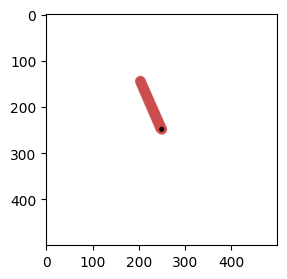

In [4]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [5]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        #根据概率采样
        mu, sigma = cql.model_action(torch.FloatTensor(state).reshape(1, 3))
        action = random.normalvariate(mu=mu.item(), sigma=sigma.item())

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

50.913929081468524

In [6]:
def train():
    for epoch in range(200):
        for i, (state, action, reward, next_state, over) in enumerate(loader):
            cql.train_value(state, action, reward, next_state, over)
            cql.train_action(state)

        if epoch % 10 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, test_result)


train()

0 13.875822089482446
10 14.038670144211011
20 43.05573207452028
30 100.48515742635345
40 155.40882508483966
50 125.87853438927903
60 104.61060542830981
70 94.20149997923656
80 141.952184150454
90 120.67394031059686
100 131.55446931288566
110 125.69580745757926
120 144.64473570363813
130 145.9575588365455
140 136.35601893991512
150 139.22819598233917
160 125.65486657275078
170 118.63061119526728
180 120.03465550187825
190 124.59026179267951


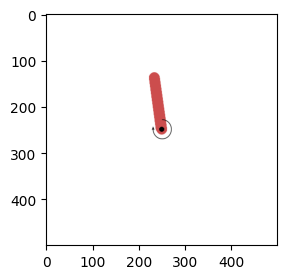

156.6398188642086

In [7]:
play(True)[-1]